# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. Есть набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Импорты

Для начала установим и загрузим необходимые для работы модули и пакеты

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.tokenize import word_tokenize
from nltk import FreqDist
! pip install pymorphy2
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
! pip install spacy
import spacy
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en
! pip install textblob
from textblob import TextBlob, Word


import matplotlib.pyplot as plt
! pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
! pip install catboost
from catboost import CatBoostClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

! pip install transformers
from transformers import BertTokenizer
from transformers import BertModel, BertConfig
import transformers
from tqdm import notebook
import torch
from tqdm import tqdm
from transformers import BertForMaskedLM




[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


KeyboardInterrupt: 

## Загрузка данных

Посмотрим на датасет

In [ ]:
df = pd.read_csv('toxic_comments (1).csv')

In [3]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Видим, что датасет содержит два столбца - с текстом клмментария и с пометкой о том, является ли комментарий токсичным

Изучим общую информацию о таблице

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Видим, что пропусков нет и типы данных соответствуют действительности. Можно переходить к предобработке

## Предобработка

### Баланс классов

Посмотрим на баланс классов

In [5]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Отметим, что классы несбалансированы

### Добавление фичей

Прежде чем добавить некоторые фичи, нужно составим множество стоп-слов

In [6]:
stop_words = set(stopwords.words('english'))

Добавляя фичи, будем ориентироваться на символ '\n' как промежуточный для длины комментария

In [7]:
# длина комментария
df['num_of_sent'] = df['text'].apply(lambda x: len(re.findall('\n',str(x)))+1)
# количество слов
df['num_of_word'] = df['text'].apply(lambda x: len(str(x).split()))
# количество уникальных слов
df['num_of_unique_word'] = df['text'].apply(lambda x: len(set(str(x).split())))
# количество символов
df['num_of_letters'] = df['text'].apply(lambda x: len(str(x)))
# количество знаков препинания
df["num_of_punct"] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
# количество слов капсом
df["num_of_words_upper"] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
# количество слов с заглавной буквы
df["num_of_words_title"] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
# количество стоп-слов
df["num_of_stopwords"] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
# средняя длина слова в тексте
df["mean_word_len"] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
# процент уникальных слов
df['word_unique_percent'] = df['num_of_unique_word']*100/df['num_of_word']
# процент знаков пунктуации
df['punct_percent'] = df['num_of_punct']*100/df['num_of_word']

Посмотрим на получившийся датафрейм

In [8]:
df

,text,toxic,num_of_sent,num_of_word,num_of_unique_word,num_of_letters,num_of_punct,num_of_words_upper,num_of_words_title,num_of_stopwords,mean_word_len,word_unique_percent,punct_percent
0,Explanation\nWhy the edits made under my usern...,0,2,43,41,264,10,2,11,18,5.162791,95.348837,23.255814
1,D'aww! He matches this background colour I'm s...,0,1,17,17,112,12,1,3,2,5.588235,100.000000,70.588235
2,"Hey man, I'm really not trying to edit war. It...",0,1,42,39,233,6,0,2,20,4.571429,92.857143,14.285714
3,"""\nMore\nI can't make any real suggestions on ...",0,5,113,82,622,21,5,7,56,4.486726,72.566372,18.584071
4,"You, sir, are my hero. Any chance you remember...",0,1,13,13,67,5,0,2,5,4.230769,100.000000,38.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,3,47,44,295,18,0,2,19,5.212766,93.617021,38.297872
159567,You should be ashamed of yourself \n\nThat is ...,0,3,18,18,99,4,0,2,11,4.388889,100.000000,22.222222
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,3,12,12,81,4,0,4,2,5.583333,100.000000,33.333333
159569,And it looks like it was actually you who put ...,0,1,25,23,116,1,1,2,15,3.680000,92.000000,4.000000


Реализуем функцию для первичной обработки текста

In [9]:
def text_prep(text):
    new_text = text.lower()
    new_text = re.sub(r"i'm", "i am", new_text)
    new_text = re.sub(r"\n", " ", new_text)
    new_text = re.sub(r"he's", "he is", new_text)
    new_text = re.sub(r"she's", "she is", new_text)
    new_text = re.sub(r"it's", "it is", new_text)
    new_text = re.sub(r"that's", "that is", new_text)
    new_text = re.sub(r"what's", "that is", new_text)
    new_text = re.sub(r"where's", "where is", new_text)
    new_text = re.sub(r"how's", "how is", new_text)
    new_text = re.sub(r"\'ll", " will", new_text)
    new_text = re.sub(r"\'ve", " have", new_text)
    new_text = re.sub(r"\'re", " are", new_text)
    new_text = re.sub(r"\'d", " would", new_text)
    new_text = re.sub(r"won't", "will not", new_text)
    new_text = re.sub(r"can't", "cannot", new_text)
    new_text = re.sub(r"n't", " not", new_text)
    new_text = re.sub(r"'bout", "about", new_text)
    new_text = re.sub(r"'til", "until", new_text)
    new_text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", new_text)

    return new_text

Применим её к нашему датафрейму

In [10]:
df['text_cleaned'] = df['text'].apply(text_prep)

In [11]:
df

,text,toxic,num_of_sent,num_of_word,num_of_unique_word,num_of_letters,num_of_punct,num_of_words_upper,num_of_words_title,num_of_stopwords,mean_word_len,word_unique_percent,punct_percent,text_cleaned
0,Explanation\nWhy the edits made under my usern...,0,2,43,41,264,10,2,11,18,5.162791,95.348837,23.255814,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,1,17,17,112,12,1,3,2,5.588235,100.000000,70.588235,d'aww he matches this background colour i am s...
2,"Hey man, I'm really not trying to edit war. It...",0,1,42,39,233,6,0,2,20,4.571429,92.857143,14.285714,hey man i am really not trying to edit war it ...
3,"""\nMore\nI can't make any real suggestions on ...",0,5,113,82,622,21,5,7,56,4.486726,72.566372,18.584071,more i cannot make any real suggestions on im...
4,"You, sir, are my hero. Any chance you remember...",0,1,13,13,67,5,0,2,5,4.230769,100.000000,38.461538,you sir are my hero any chance you remember wh...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,3,47,44,295,18,0,2,19,5.212766,93.617021,38.297872,and for the second time of asking when your vi...
159567,You should be ashamed of yourself \n\nThat is ...,0,3,18,18,99,4,0,2,11,4.388889,100.000000,22.222222,you should be ashamed of yourself that is a ...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,3,12,12,81,4,0,4,2,5.583333,100.000000,33.333333,spitzer umm theres no actual article for pro...
159569,And it looks like it was actually you who put ...,0,1,25,23,116,1,1,2,15,3.680000,92.000000,4.000000,and it looks like it was actually you who put ...


### Стоп-слова

Удалим стоп-слова

In [14]:
toxic_df = df[df['toxic'] == 1]
not_toxic_df = df[df['toxic'] == 0]

In [15]:
df = pd.concat([toxic_df.sample(n=3000, random_state=42)] + [not_toxic_df.sample(n=7000, random_state=42)])
df['toxic'].value_counts()

0    7000
1    3000
Name: toxic, dtype: int64

In [16]:
for index, row in df.iterrows(): 
    df['text_cleaned'][index] = [word for word in str(row['text_cleaned']).split() if not word in stop_words]
    df['text_cleaned'][index] = re.sub('[,—\"\'\[\]]', '', str(df['text_cleaned'][index]))

/tmp/ipykernel_398/787805469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_cleaned'][index] = [word for word in str(row['text_cleaned']).split() if not word in stop_words]
/tmp/ipykernel_398/787805469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_cleaned'][index] = re.sub('[,—\"\'\[\]]', '', str(df['text_cleaned'][index]))


In [17]:
df

,text,toxic,num_of_sent,num_of_word,num_of_unique_word,num_of_letters,num_of_punct,num_of_words_upper,num_of_words_title,num_of_stopwords,mean_word_len,word_unique_percent,punct_percent,text_cleaned
45045,"""\nI was talking about them running any check ...",1,2,117,91,581,22,7,8,66,3.905983,77.777778,18.803419,talking running check want disprove claims kno...
27198,White Trash\nFuck off you white piece of trash...,1,2,18,18,93,4,0,7,5,4.222222,100.000000,22.222222,white trash fuck white piece trash fucking wig...
16664,eat shit get rid of goofs you queers.,1,1,8,8,37,1,0,0,2,3.750000,100.000000,12.500000,eat shit get rid goofs queers
8158,DUMB ASSES\nIt's was my sockpuppet...joe hazet...,1,2,68,65,398,29,33,3,32,4.852941,95.588235,42.647059,dumb asses sockpuppetjoe hazeton guys control ...
142212,"Are all professors of rhetoric pompous, self-c...",1,1,13,13,83,4,0,2,7,5.384615,100.000000,30.769231,professors rhetoric pompous selfcentered assholes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158809,"""\n\n HOW CAN U JUDGE A SPORT PERSONALIT...",0,7,112,81,686,48,109,9,41,4.937500,72.321429,42.857143,u judge sport personalityjust basis headbutt w...
3687,Thanks for the welcome \n\nThanks Tom for the ...,0,3,72,56,376,14,5,12,34,4.208333,77.777778,19.444444,thanks welcome thanks tom warm welcome see pat...
118353,"Sorry, but creating an article is not exclusiv...",0,1,64,52,348,9,0,7,35,4.453125,81.250000,14.062500,sorry creating article exclusive editing artic...
146246,I did some math to get more precise population...,0,3,49,43,278,10,1,4,23,4.673469,87.755102,20.408163,math get precise population density rather 0km...


In [179]:
# Сохраним подготовленный CSV
df.to_csv('df_prep.csv')

### Лемматизация

Лемматизируем комментарии

In [149]:
df = pd.read_csv('df_prep.csv')

In [21]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [22]:
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

# Lemmatize
sentence = "The striped bats are hanging on their feet for best"
lemmatize_with_postag(sentence)

'The striped bat be hang on their foot for best'

In [181]:
df['text_cleaned_new'] = df['text_cleaned'].apply(lemmatize_with_postag)

In [182]:
df.head(10)

In [198]:
df

Для удобства сохраним подготовленный датафрейм

In [199]:
# Сохраним подготовленный CSV
df.to_csv('comments.csv')

<div style="border:solid blue 2px; padding: 20px">

**Выводы**

В результате предобработки были добавлены следующие фичи:
* количество символов '\n'
* количество слов
* количество уникальных слов
* количество символов
* количество знаков препинания
* количество слов капсом
* количество слов с заглавной буквы
* количество стоп-слов
* средняя длина слова в тексте
* процент уникальных слов
* процент знаков пунктуации

Кроме того, был добавлен столбец с предобработанным текстом: он был токенизирован, в нём были удалены стоп-слова и он был лемматизирован

Можно переходить к анализу данных

## Анализ данных

In [233]:
df = pd.read_csv('comments.csv')

In [234]:
df

### Word Cloud

Посмотрим, какие слова чаще всего встречаются в токсичных комментариях

Для начала представим все токсичные комментарии как строку 

In [235]:
toxic_as_str = ''

Добавим в строку сами комментарии

In [236]:
for index, row in df.iterrows(): 
    if row['toxic'] == 1:
        toxic_as_str = toxic_as_str + str(row['text_cleaned_new']) + ' '

Посмотрим на получившуюся строку

In [237]:
toxic_as_str

При помощи регулярных выражений удалим лишние символы

In [238]:
toxic_as_str = re.sub('[,—\'\[\]]', '', toxic_as_str)

In [239]:
toxic_as_str

Составим "словарь" из 50 наиболее частотных слов

In [240]:
toxic_tokens = word_tokenize(toxic_as_str)

In [241]:
toxic_text = nltk.Text(toxic_tokens)

In [242]:
fdist_toxic = FreqDist(toxic_text)

In [243]:
fdist_toxic_most_c = fdist_toxic.most_common(50)

Визуализируем облако частотных слов

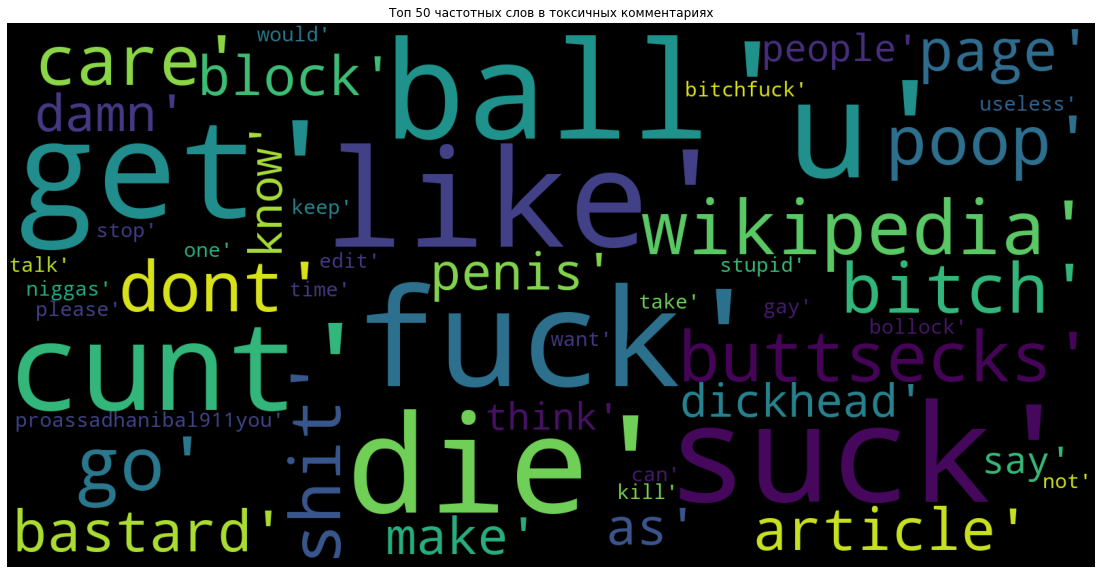

In [244]:
# Создаем текст для облака частотных слова
text_wordcloud= ' '.join(map(str, fdist_toxic_most_c)) 
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=100,background_color="black", collocations=True).generate(text_wordcloud)

# Визуализация 
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title('Топ 50 частотных слов в токсичных комментариях')
plt.axis("off")
plt.show()

Далее посмотрим, отличаются ли наши подготовленные фичи для токсичных и не токсичных комметариев

### Распределения по токсичным и не токсичным комментариям

In [245]:
df

In [246]:
toxic_df = df[df['toxic'] == 1]
not_toxic_df = df[df['toxic'] == 0]

Поскольку далее будут одни и те же действия применяться к нескольким столбцам, реализуем функцию

In [247]:
def distribution(col, title):
    plt.figure(figsize=(28,8))
    ax = sns.boxplot(y='toxic', x=str(col), data=df, orient="h").set_title(title)
    print('Распределние для токсичных комментариев:\n')
    print(toxic_df[str(col)].describe())
    print('\nРаспределние для не токсичных комментариев:\n')
    print(not_toxic_df[str(col)].describe())
    print('\n\n')

#### Количество символов '\n'

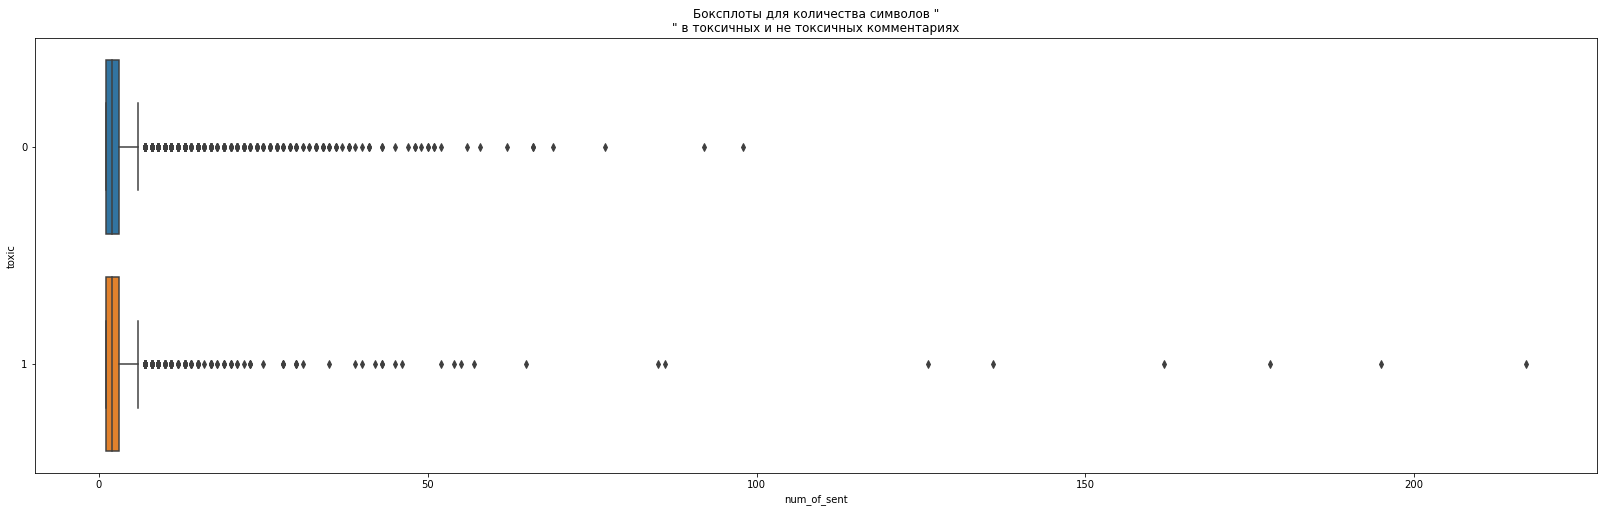

In [248]:
distribution('num_of_sent', 'Боксплоты для количества символов "\n" в токсичных и не токсичных комментариях')

Видим, что большой разницы в данных нет

#### Количество слов

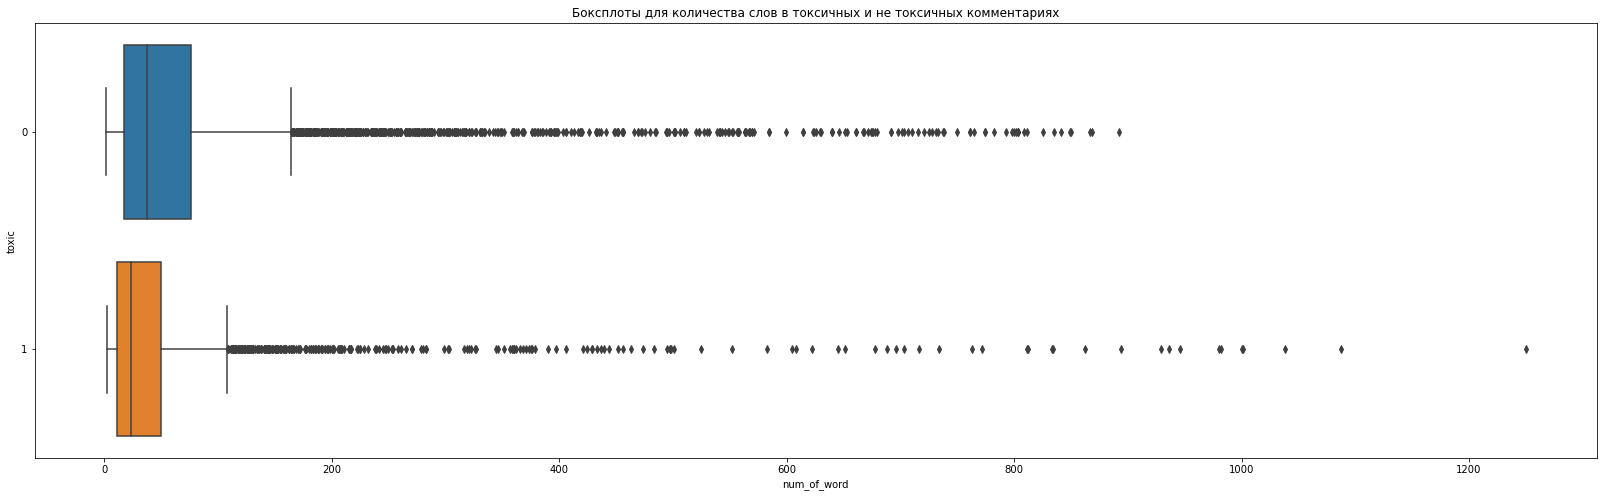

In [249]:
distribution('num_of_word', 'Боксплоты для количества слов в токсичных и не токсичных комментариях')

Не токсичные комментарии на удивление в среднем оказываются даже длиннее

#### Количество уникальных слов

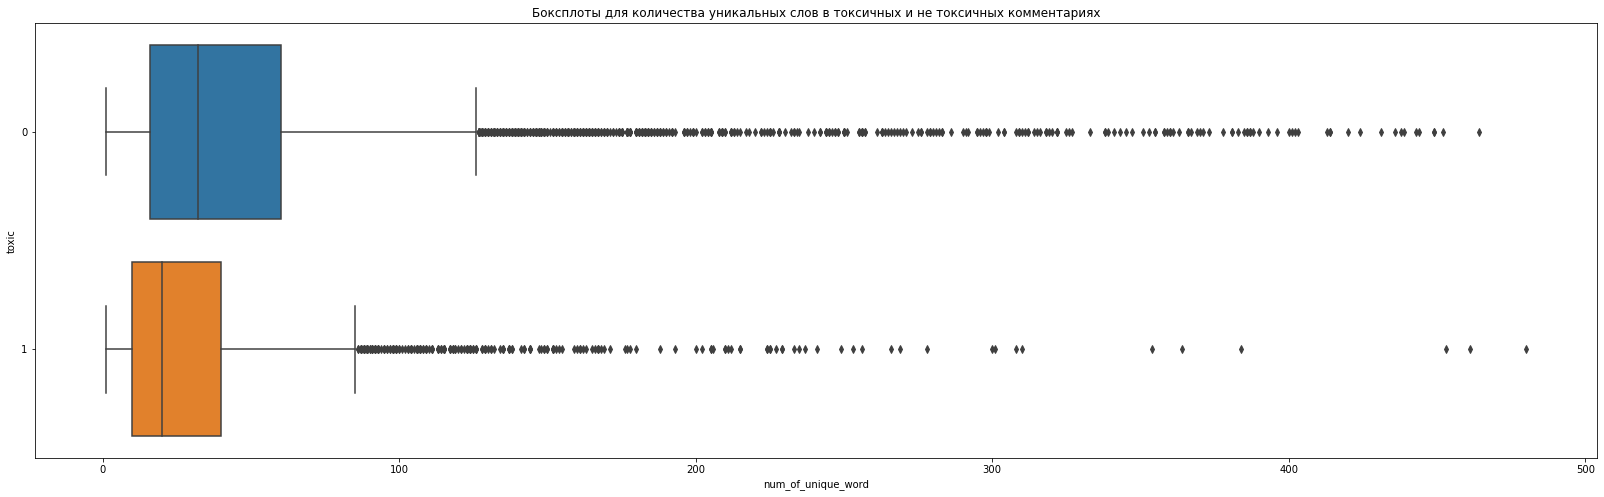

In [250]:
distribution('num_of_unique_word', 'Боксплоты для количества уникальных слов в токсичных и не токсичных комментариях')

Количество уникальных слов в среднем в не токсичных комментариях тоже больше

#### Количество символов

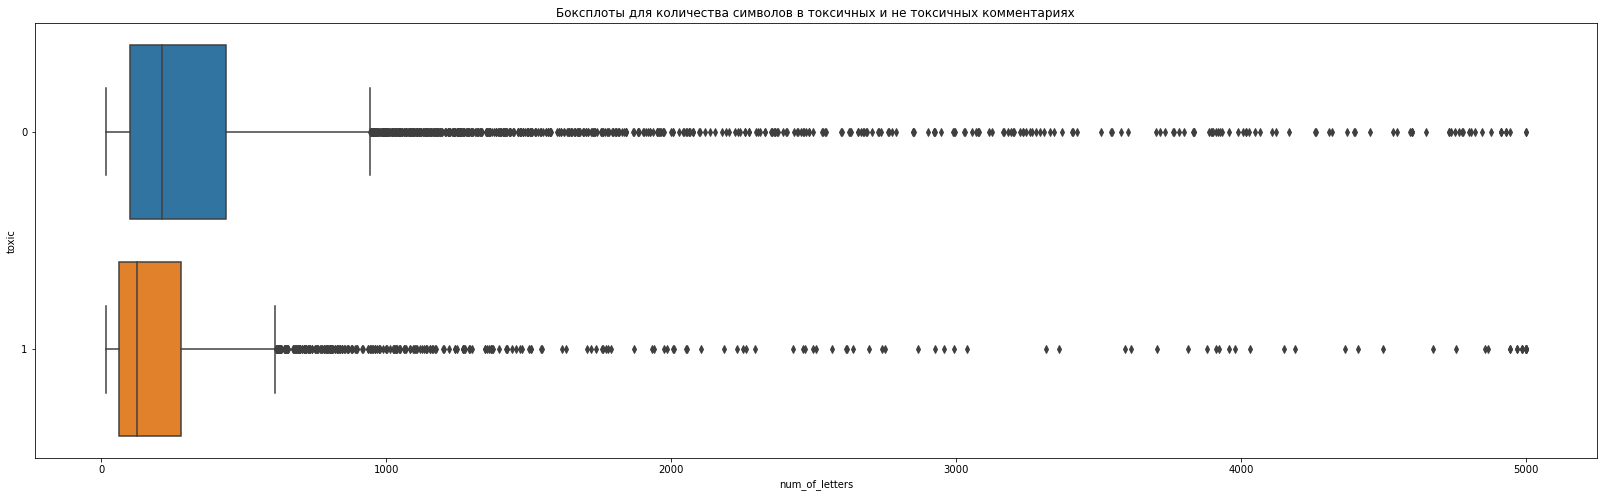

In [251]:
distribution('num_of_letters', 'Боксплоты для количества символов в токсичных и не токсичных комментариях')

Кроме того, в токсичных комментариях в среднем меньше символов

#### Количество знаков препинания

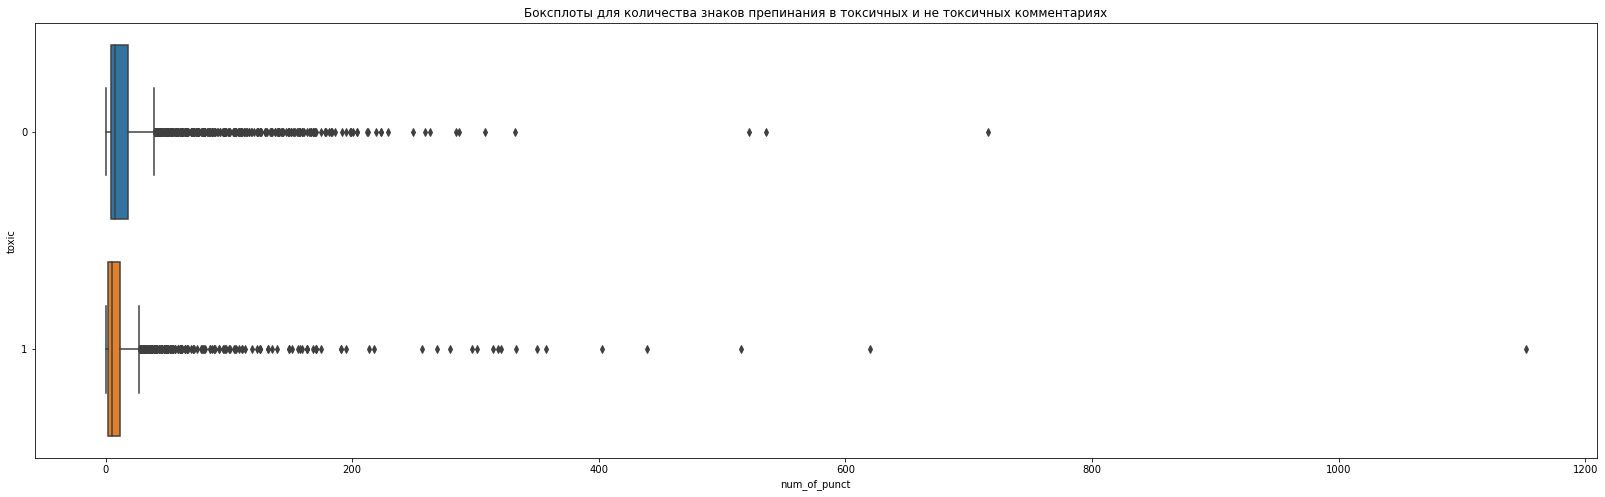

In [252]:
distribution('num_of_punct', 'Боксплоты для количества знаков препинания в токсичных и не токсичных комментариях')

Количество знаков препинания в целом одинаковое

#### Количество слов капсом

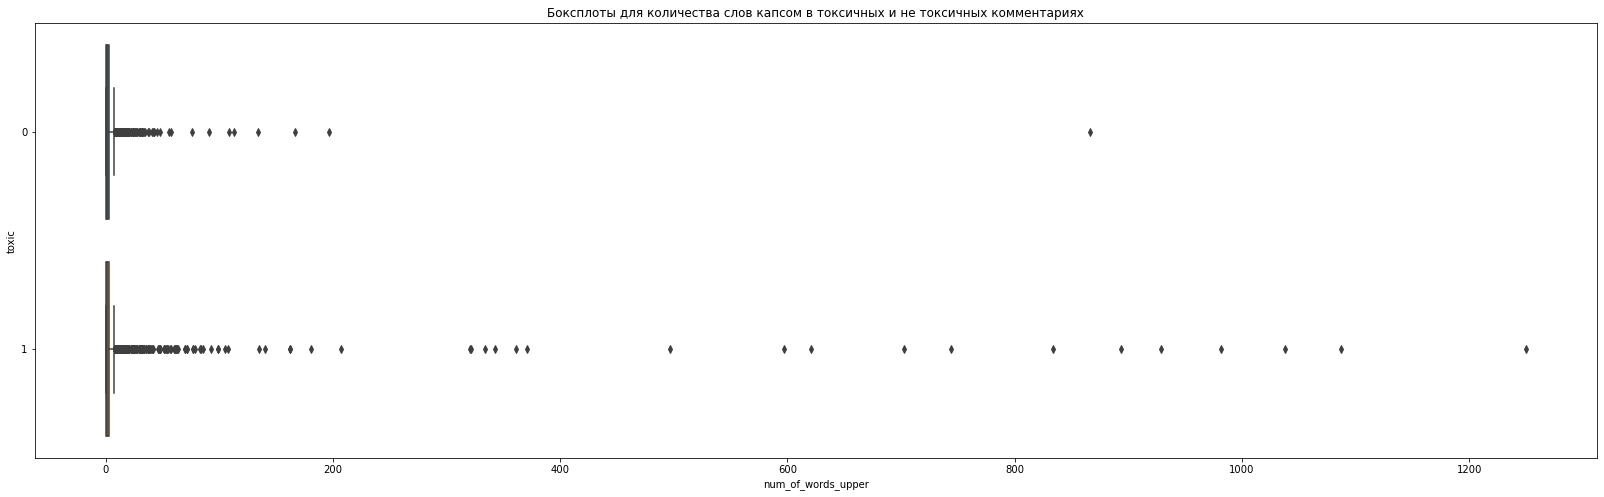

In [253]:
distribution('num_of_words_upper', 'Боксплоты для количества слов капсом в токсичных и не токсичных комментариях')

Капсом люди в данных комментариях практически не пользуются

#### Количество слов с заглавной буквы

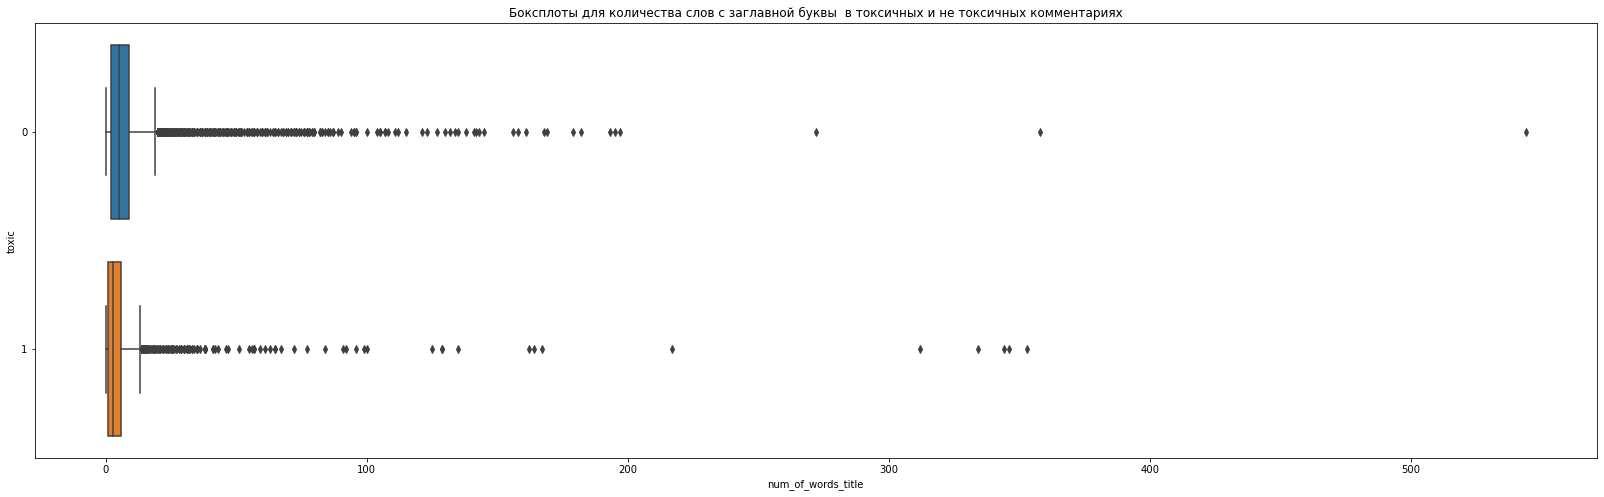

In [254]:
distribution('num_of_words_title', 'Боксплоты для количества слов с заглавной буквы  в токсичных и не токсичных комментариях')

И заглавные буквы авторы обоих видов комментариев используют примерно одинаково

#### Количество стоп-слов

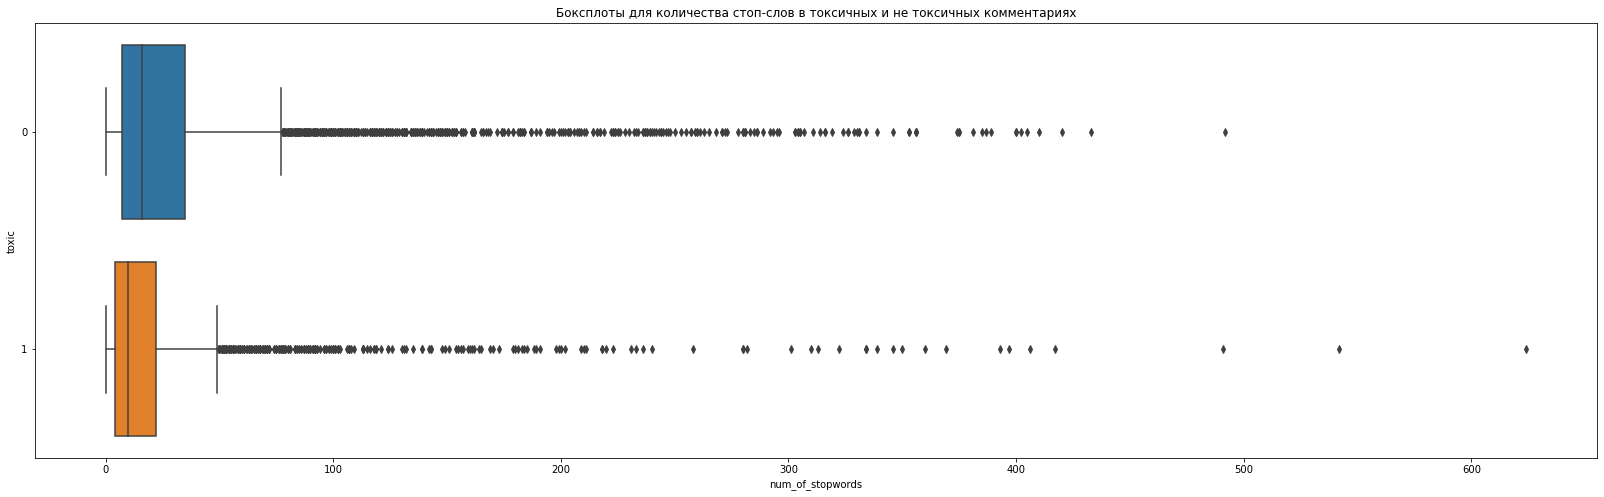

In [255]:
distribution('num_of_stopwords', 'Боксплоты для количества стоп-слов в токсичных и не токсичных комментариях')

Количество стоп-слов тоже схоже - в нетоксичных комментариях их в среднем больше только за счёт того, что всего слов в среднем больше

#### Средняя длина слова в тесте

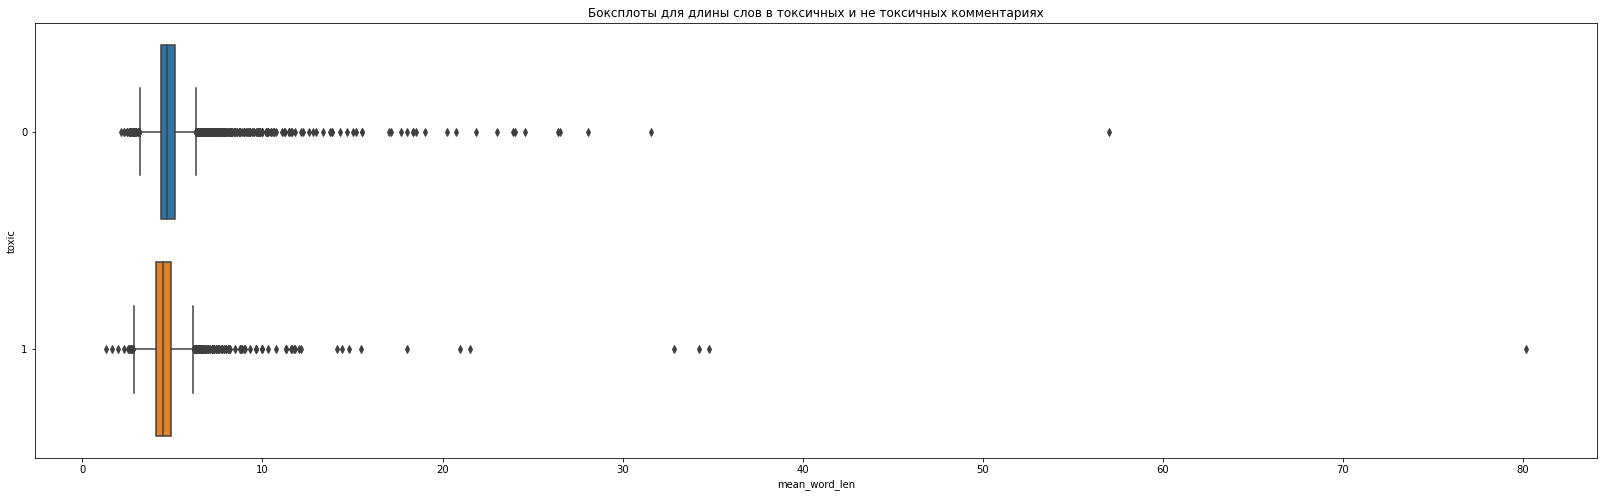

In [256]:
distribution('mean_word_len', 'Боксплоты для длины слов в токсичных и не токсичных комментариях')

Видим, что средняя длина слова в тесте тоже не так сильно отличается, хотя в токсичных комментариях встречается больше аномальных значений

#### Процент уникальных слов

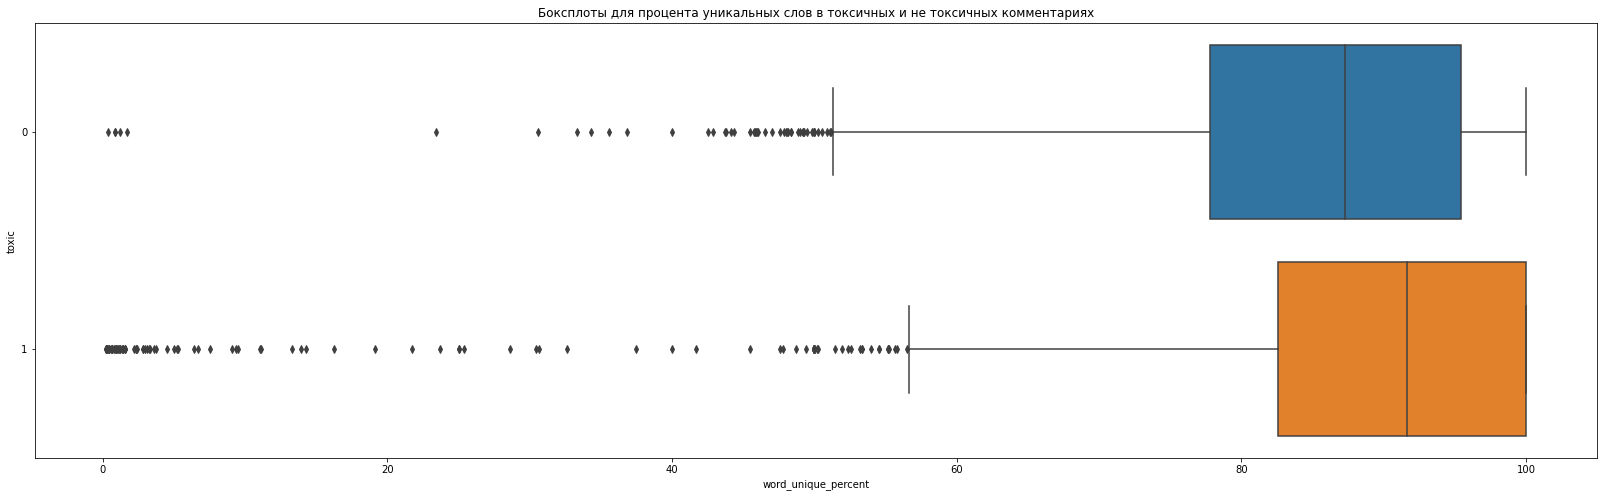

In [257]:
distribution('word_unique_percent', 'Боксплоты для процента уникальных слов в токсичных и не токсичных комментариях')

Распределения в целом схожи

#### Процент знаков пунктуации

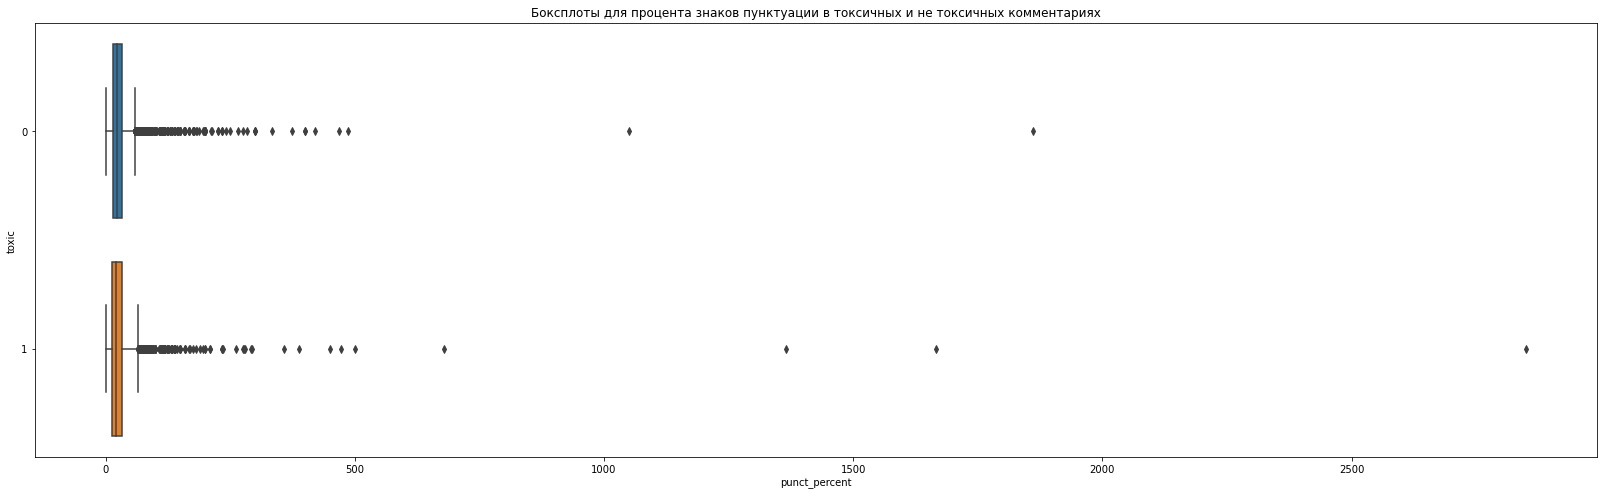

In [258]:
distribution('punct_percent', 'Боксплоты для процента знаков пунктуации в токсичных и не токсичных комментариях')

Видим опять же схожие распределения, хотя в токстных комметариях больше аномалий

<div style="border:solid blue 2px; padding: 20px">

**Выводы**

В ходе анализа данных было составлено облако слов для токсичных комментариев и рассмотрены распределения по основным фичам. Из основных различий, которые были замечены, можно отметить, что в среднем не токсичные комментарии всё же длинее, а в токсичных комментариях встречается больше аномалий по ряду параметров.

## ML

Поскольку при работе на всём датасете, ядро умирает, возьмём часть датасета, причём поровну из разных классов, поскольку у нас наблюдается сильный дисбаланс.

Соотношение классов 1:9

Отложим тестовую выборку в таком же соотношении

In [259]:
df_test = pd.concat([toxic_df.sample(n=200, random_state=42)] + [not_toxic_df.sample(n=1800, random_state=42)])
df_test['toxic'].value_counts()

In [260]:
df_short = pd.concat([df, df_test]).drop_duplicates(keep=False)
df_short = pd.concat([toxic_df.sample(n=2000, random_state=42)] + [not_toxic_df.sample(n=2000, random_state=42)])
df_short['toxic'].value_counts()

In [261]:
df_short

Выделим целевой признак и фичи

In [262]:
target = df_short['toxic']
features = df_short.drop(['toxic', 'text', 'Unnamed: 0', 'text_cleaned'], axis=1)

In [263]:
target_test = df_test['toxic']
features_test = df_test.drop(['toxic', 'text', 'Unnamed: 0',  'text_cleaned'], axis=1)

Разобьём данные на обучающую и тестовую выборку. В качестве размера теста возьмём 30%

In [264]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=.3, shuffle=True)

### Обучение

#### TF IDF

Будем использовать TfidfVectorizer

In [265]:
corpus_train = features_train['text_cleaned_new']

In [266]:
corpus_valid = features_valid['text_cleaned_new']

In [267]:
count_tf_idf = TfidfVectorizer()
tf_idf = count_tf_idf.fit(corpus_train)

In [268]:
tf_idf = count_tf_idf.transform(corpus_train)

In [269]:
tf_idf_valid = count_tf_idf.transform(corpus_valid)

Обучим разные модели

#### Логистическая регрессия

In [270]:
model = LogisticRegression(random_state=42, solver = 'liblinear', max_iter=5000)

In [271]:
model.fit(tf_idf, target_train)


In [272]:
predicted = pd.Series(model.predict(tf_idf_valid))

Посмотрим на f1 меру

In [273]:
f1_score(predicted, target_valid).round(3)


#### Catboost

In [274]:
cat_model = CatBoostClassifier(custom_loss='F1')
cat_model.fit(tf_idf, target_train)
predicted_cat = pd.Series(cat_model.predict(tf_idf_valid))

In [275]:
f1_score(predicted_cat, target_valid).round(3)

##### CatBoost "из коробки"

In [277]:
cat_model = CatBoostClassifier(custom_loss='F1', text_features=['text_cleaned_new'])
cat_model.fit(features_train, target_train)
predicted_cat = pd.Series(cat_model.predict(features_valid))

In [278]:
f1_score(predicted_cat, target_valid).round(3)

#### LightGBM

In [279]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'F1',
    'max_depth': 6, 
    'learning_rate': 0.4,
    'verbose': 0
}

In [280]:
lgbm_model = LGBMClassifier(**params)
lgbm_model.fit(tf_idf, target_train)
predictions_lgbm = lgbm_model.predict(tf_idf_valid)

In [281]:
f1_score(predictions_lgbm, target_valid).round(3)

#### Bert

In [300]:
model = BertModel.from_pretrained('bert-base-uncased')
model.eval();


In [301]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [302]:
tokenized = df_short['text_cleaned_new'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512))

In [303]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
        
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
padded.shape

In [304]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

In [305]:
batch_size = 50
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

In [306]:
bert_features = np.concatenate(embeddings)
bert_target = df_short['toxic']

bert_train_features, bert_test_features, bert_train_target, bert_test_target = train_test_split(bert_features, bert_target, test_size=1500)


Обучим логистическую регрессию на предобработке BERT

In [307]:
model_l = LogisticRegression(random_state=42, solver = 'liblinear', max_iter=5000)
model_l.fit(bert_train_features, bert_train_target)
predicted_2 = pd.Series(model_l.predict(bert_test_features))

In [308]:
f1_score(predicted_2, bert_test_target).round(3)

### Проверка на тесте

#### Catboost

In [310]:
cat_model = CatBoostClassifier(custom_loss='F1', text_features=['text_cleaned_new'])
cat_model.fit(features_train, target_train)
predicted_cat = pd.Series(cat_model.predict(features_test))

In [311]:
f1_score(predicted_cat, target_test).round(3)

#### BERT + логрег

In [312]:
model = BertModel.from_pretrained('bert-base-uncased')
model.eval();

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [313]:
tokenized = features_test['text_cleaned_new'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512))

In [314]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
        
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
padded.shape

In [315]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

In [316]:
batch_size = 50
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

In [317]:
bert_features = np.concatenate(embeddings)
bert_target = target_test

Обучим логистическую регрессию на предобработке BERT

In [318]:
predicted_2 = pd.Series(model_l.predict(bert_features))

In [319]:
f1_score(predicted_2, bert_target).round(3)

<div style="border:solid blue 2px; padding: 20px">

**Выводы**

На этом шаге были рассмотрены модели логистической регрессии, Catboost и LightGBM. Наилучший результат показала модель Catboost. F1 мера равна 0.796

## Вывод

В ходе работы над проектом были рассмотрены данные с токсичными и не токсичными комментариями. В датасет были добавлены фичи с основной информацией, которую можно получить из комментариев, после чего данные были токенизированы, из них были удалены стоп-слова и была произведена лемматизация. 

На этапе анализа были отражены наиболее часто встречающиеся слова в токсичных комментариях и были рассмотрены основные числовые показатели для токсичных и не токсичных комментариев. Токсичные комментарии в целом короче и в низ встречается больше аномальных значений признаков. 

Далее была произведена процедура TF IDF и были рассмотрены следующие модели машинного обучения: Логистическая регрессия, Catboost и LightGBM.

В результате была выбрана модель Catboost

Итоговая F1 мера 0.796